# Create CIGALE data file for (VIKING+DES+CATWISE) sources

Select a subsample of VIKING+DES+CATWISE sources that have the same distribution as EMU sources in a given magnitude.

# Import Libraries

In [1]:
import numpy as np
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import missingno

# Define the directory

In [2]:
observatory = '/home/mfonseca/fastdisk'
my_computer = '/home/polaris/Lab_Astro/data/'

directory = my_computer

# Import data

## Import EMU+VIKING+DES+CATWISE crossmatch data

In [3]:
emu_matched_no_mags_path = directory + 'cross_match/EMU_0102-32_DESY6GOLD_VIKING_CATWISE_noMags/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag_petro_2.fits'
emu_matched_no_mags = Table.read(emu_matched_no_mags_path).filled()
emu_matched_no_mags = emu_matched_no_mags.to_pandas()

match_mask = (emu_matched_no_mags['match_flag'] == 1) & (emu_matched_no_mags['p_i'] >= 0.1) & (emu_matched_no_mags['p_any'] >=0.83)
catalog_matches_noMags = emu_matched_no_mags[match_mask]
print(f'Number of objects in the catalog {len(catalog_matches_noMags)}')

# Here we select objects that have matches in all three surveys
full_match_mask = (catalog_matches_noMags['DESY6_coadd_object_id'] != -99) & (catalog_matches_noMags['VKG_sourceID'] != -99) & (catalog_matches_noMags['CAT_source_id'] != b'-99')
emu_catalog_matches_noMags_full = catalog_matches_noMags[full_match_mask]

# Ignore the warning
emu_catalog_matches_noMags_full['EMU_island_name'] = emu_catalog_matches_noMags_full['EMU_island_name'].str.decode('utf-8').str.strip(' ')

print(f'Number of objects in the catalog that have matches in all three surveys {len(emu_catalog_matches_noMags_full)}')

emu_catalog_matches_noMags_full.drop(columns=['DESY6_mag_auto_y_extcorr', 'DESY6_z_y_extcorr','VKG_magerr_petro_z', 'VKG_mag_petro_z_ab_extcorr'], inplace=True)
emu_catalog_matches_noMags_full.dropna(inplace=True)

print(f'Number of objects in the catalog that have matches in all three surveys and have full photometry {len(emu_catalog_matches_noMags_full)}')

Number of objects in the catalog 11695
Number of objects in the catalog that have matches in all three surveys 3855
Number of objects in the catalog that have matches in all three surveys and have full photometry 3530


/tmp/ipykernel_13997/2011678717.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emu_catalog_matches_noMags_full['EMU_island_name'] = emu_catalog_matches_noMags_full['EMU_island_name'].str.decode('utf-8').str.strip(' ')
/tmp/ipykernel_13997/2011678717.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emu_catalog_matches_noMags_full.drop(columns=['DESY6_mag_auto_y_extcorr', 'DESY6_z_y_extcorr','VKG_magerr_petro_z', 'VKG_mag_petro_z_ab_extcorr'], inplace=True)
/tmp/ipykernel_13997/2011678717.py:19: SettingWithCopyWarning: 
A value is trying to be set on a co

## Import VIKING+DES+CATWISE crossmatch data

In [9]:
other_matched_no_mags_path = directory + 'cross_match/without_EMU/DESY6_VKG_CAT_noMags/DESY6_VKG_CAT_noMags.fits'
other_matched_no_mags = Table.read(other_matched_no_mags_path).filled()
other_matched_no_mags = other_matched_no_mags.to_pandas()

# Match criteria from NWAY
match_mask = (other_matched_no_mags['match_flag'] == 1) & (other_matched_no_mags['p_i'] > 0.1) & (other_matched_no_mags['p_any'] >0.00)
other_catalog_matches_noMags = other_matched_no_mags[match_mask]
print(f'Number of objects in the catalog {len(other_catalog_matches_noMags)}')

# Here we select objects that have matches in DES and CATWISE surveys
full_match_mask = (other_catalog_matches_noMags['DESY6_coadd_object_id'] != -99) & (other_catalog_matches_noMags['CAT_source_id'] != b'-99')
other_catalog_matches_noMags_full = other_catalog_matches_noMags[full_match_mask]

print(f'Number of objects in the catalog that have matches in all three surveys {len(other_catalog_matches_noMags_full)}')

Number of objects in the catalog 587677
Number of objects in the catalog that have matches in all three surveys 366961


## Remove EMU+VIKING+DES+CATWISE crossmatch data from VIKING+DES+CATWISE

In [11]:
# Columns to compare (same names in both DataFrames)
compare_cols = ['DESY6_coadd_object_id', 'VKG_sourceID', 'CAT_source_name']

# Step 1: Create a merge key to identify matching rows
other_catalog_matches_noMags_full['_merge_key'] = other_catalog_matches_noMags_full[compare_cols].astype(str).agg('_'.join, axis=1)
emu_catalog_matches_noMags_full['_merge_key'] = emu_catalog_matches_noMags_full[compare_cols].astype(str).agg('_'.join, axis=1)

# Step 2: Remove rows from df1 where values in compare_cols match any row in df2
non_emu_fullphot_filtered = other_catalog_matches_noMags_full[~other_catalog_matches_noMags_full['_merge_key'].isin(emu_catalog_matches_noMags_full['_merge_key'])].copy()

# Step 3: Drop the helper column
non_emu_fullphot_filtered.drop(columns=['_merge_key'], inplace=True)
emu_catalog_matches_noMags_full.drop(columns=['_merge_key'], inplace=True)

# Step 4: Add source_flag (0 = from other_catalog_matches_noMags_full, 1 = from emu_catalog_matches_noMags_full)
# other_catalog_matches_noMags_full['source_flag'] = 0
# emu_catalog_matches_noMags_full['source_flag'] = 1

# Step 5: Append df2 to the filtered df1
# final_df = pd.concat([other_catalog_matches_noMags_full, emu_catalog_matches_noMags_full], ignore_index=True)
final_df = non_emu_fullphot_filtered

print(f'Number of objects in the catalog that have matches in all three surveys and have full photometry but are not in EMU {len(final_df)}')

/tmp/ipykernel_13997/2347824584.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_catalog_matches_noMags_full['_merge_key'] = other_catalog_matches_noMags_full[compare_cols].astype(str).agg('_'.join, axis=1)
/tmp/ipykernel_13997/2347824584.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emu_catalog_matches_noMags_full['_merge_key'] = emu_catalog_matches_noMags_full[compare_cols].astype(str).agg('_'.join, axis=1)


Number of objects in the catalog that have matches in all three surveys and have full photometry but are not in EMU 363431


/tmp/ipykernel_13997/2347824584.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emu_catalog_matches_noMags_full.drop(columns=['_merge_key'], inplace=True)


# Select a subsample of VIKING+DES+CATWISE with similar distribution to EMU+VIKING+DES+CATWISE

In [13]:
def match_distribution_by_binning(df1, df2, column, bins, random_state=None):
    """
    Selects a subsample of df1 to match the distribution of df2 in `column` by binning.
    
    Parameters:
    - df1: pandas DataFrame (larger dataset to sample from)
    - df2: pandas DataFrame (reference dataset with desired distribution)
    - column: str, the column name to match distribution on
    - bins: int or sequence, bins for the column
    - random_state: int or None, for reproducibility
    
    Returns:
    - df1_subsample: pandas DataFrame, subsample of df1 matching df2's distribution in `column`
    """
    rng = np.random.default_rng(random_state)
    
    # Bin the values in both dataframes
    df1['bin'] = pd.cut(df1[column], bins=bins, include_lowest=True)
    df2['bin'] = pd.cut(df2[column], bins=bins, include_lowest=True)
    
    # Count number of objects per bin in df2
    counts_df2 = df2['bin'].value_counts().sort_index()
    
    subsample_indices = []
    
    # For each bin, sample from df1
    for b, count in counts_df2.items():
        # Select rows in df1 belonging to bin b
        df1_bin = df1[df1['bin'] == b]
        
        if len(df1_bin) == 0:
            # No data to sample from in this bin
            continue
        
        # Number to sample: min of count in df2 and available in df1
        n_sample = min(count, len(df1_bin))
        
        # Randomly sample indices without replacement
        sampled_idx = rng.choice(df1_bin.index, size=n_sample, replace=False)
        subsample_indices.extend(sampled_idx)
    
    # Subsample df1 accordingly
    df1_subsample = df1.loc[subsample_indices].copy()
    
    # Optionally drop the 'bin' helper column
    df1_subsample.drop(columns=['bin'], inplace=True)
    df1.drop(columns=['bin'], inplace=True)
    df2.drop(columns=['bin'], inplace=True)
    
    return df1_subsample

In [20]:
bins = np.linspace(emu_catalog_matches_noMags_full['DESY6_mag_auto_g_extcorr'].min(), emu_catalog_matches_noMags_full['DESY6_mag_auto_g_extcorr'].max(), 100)
subsample_df1 = match_distribution_by_binning(final_df, emu_catalog_matches_noMags_full, 'DESY6_mag_auto_g_extcorr', bins, random_state=42)

# Save the subsample to a new file
subsample_df1.to_csv('/home/polaris/Lab_Astro/data/cigale/nonemu_data/nonemu_data_sample.csv', index=False)

/tmp/ipykernel_13997/1202171969.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['bin'] = pd.cut(df2[column], bins=bins, include_lowest=True)
/tmp/ipykernel_13997/1202171969.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(columns=['bin'], inplace=True)


# SANITY CHECK: Plot the distributions 

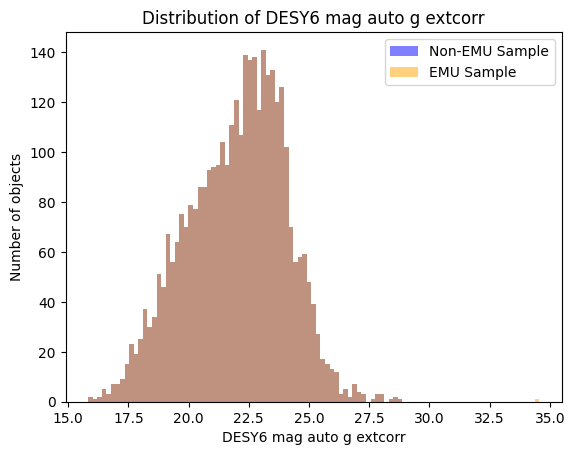

In [21]:
plt.hist(subsample_df1['DESY6_mag_auto_g_extcorr'], bins=bins, alpha=0.5, label='Non-EMU Sample', color='blue')
plt.hist(emu_catalog_matches_noMags_full['DESY6_mag_auto_g_extcorr'], bins=bins, alpha=0.5, label='EMU Sample', color='orange')
plt.xlabel('DESY6 mag auto g extcorr')
plt.ylabel('Number of objects')
plt.legend()
plt.title('Distribution of DESY6 mag auto g extcorr')
plt.show()